In [4]:
import numpy as np

from helpers import *
from implementations import * 
from utilities.logistic_regression import * #todo specify with the ones we use
from utilities.linear_regression import * #todo specify with the ones we use
from utilities.cross_validation import * #todo specify with the ones we use

In [5]:
# Load the dataset
x_tr_o, x_te_o, y_tr, tr_id, te_id = load_csv_data('dataset', True)
# Transform our y values from {-1,1} to {0,1} because that’s what logistic regression tests expect https://edstem.org/eu/courses/1605/discussion/134447
y_tr[y_tr == -1] = 0

In [6]:
x_tr = x_tr_o.copy()
x_te = x_te_o.copy()

### Data exploration and data cleaning

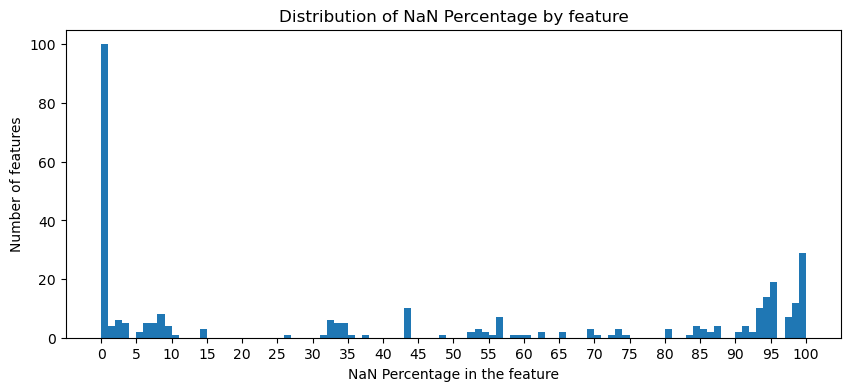

In [7]:
"""
We analyze the percentage of NaN values in each feature to determine an appropriate cutoff threshold.
Features with too many NaN values are less useful, but we don’t want to remove too many features.

number of features left for each threshold value:
   5% nan: 115 -> 35% of features left
  50% nan: 174 -> 54%
  65% nan: 194 -> 60%
  90% nan: 222 -> 69%
we pick a threshold of 50% for now.
TODO: test difference in accuracy with different thresholds {5, 50, 65, 90}%
"""

# Count the percentage of NaN values per feature
nan_percentage_by_feature = (np.sum(np.isnan(x_tr), axis=0) / len(x_tr)) * 100

# Plot the resulting distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(nan_percentage_by_feature, bins=100)
plt.title("Distribution of NaN Percentage by feature")
plt.xlabel("NaN Percentage in the feature")
plt.ylabel("Number of features")
plt.xticks(np.arange(start=0, stop=101, step=5))

# A threshold of maximum 50% of NaN values in a feature seems like a reasonable tradeoff
MAX_NAN_PERCENTAGE = 50
mask = nan_percentage_by_feature < MAX_NAN_PERCENTAGE
# So we get rid of the features with more than MAX_NAN_PERCENTAGE % of NaN values
x_tr = x_tr.copy()[:, mask]
x_te = x_te.copy()[:, mask]
from_tr_threshold_to_original_tr_indices = np.where(mask)[0]

Text(0.5, 1.0, 'Distribution of Unique Values Across Features')

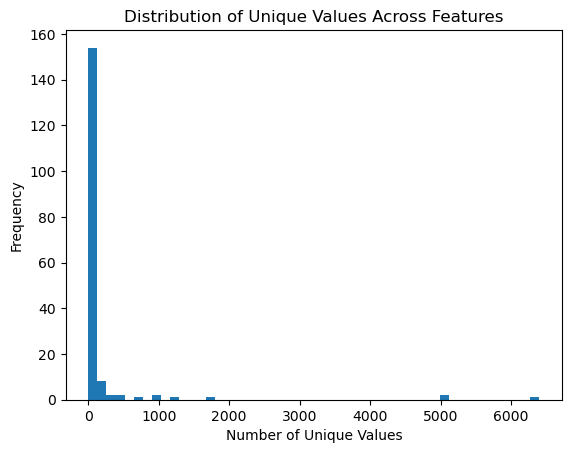

In [8]:
# Our objective is to build a mask to separate numerical and co (categorical/ordinal) data. 
# First we explore the data to see what is the maximum number of unique values for a co feature.

# Compute and plot the distribution of unique values 
unique_counts_and_indices = np.array([[len(np.unique(x_tr[:, i])),i] for i in range(x_tr.shape[1])])
unique_counts = unique_counts_and_indices[:,0]

import matplotlib.pyplot as plt

plt.hist(unique_counts, bins=50) #todo naive visualization, just to have an idea
plt.xlabel('Number of Unique Values')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Values Across Features')

In [9]:
# we consider that a feature with less than 10 values can be considered co, and more than 60 values is 
# surely numerical (think about a human having to check 100 options)
# Our goal is still to find the co feature with the most distinct values to use it as a threshold.
unique_counts_and_indices_refined = unique_counts_and_indices[(unique_counts_and_indices[:,0] > 10) & (unique_counts_and_indices[:,0] < 60)]
indices_to_consider = from_tr_threshold_to_original_tr_indices[unique_counts_and_indices_refined[:,1]] #we get back the original indexes of our x_tr to link our findings to the original feature indices.

In [10]:
x_label = np.array(["_STATE", "FMONTH", "IDATE", "IMONTH", "IDAY", "IYEAR", "DISPCODE", "SEQNO", "_PSU", "CTELENUM", "PVTRESD1", "COLGHOUS", "STATERES", "CELLFON3", "LADULT", "NUMADULT", "NUMMEN", "NUMWOMEN", "CTELNUM1", "CELLFON2", "CADULT", "PVTRESD2", "CCLGHOUS", "CSTATE", "LANDLINE", "HHADULT", "GENHLTH", "PHYSHLTH", "MENTHLTH", "POORHLTH", "HLTHPLN1", "PERSDOC2", "MEDCOST", "CHECKUP1", "BPHIGH4", "BPMEDS", "BLOODCHO", "CHOLCHK", "TOLDHI2", "CVDSTRK3", "ASTHMA3", "ASTHNOW", "CHCSCNCR", "CHCOCNCR", "CHCCOPD1", "HAVARTH3", "ADDEPEV2", "CHCKIDNY", "DIABETE3", "DIABAGE2", "SEX", "MARITAL", "EDUCA", "RENTHOM1", "NUMHHOL2", "NUMPHON2", "CPDEMO1", "VETERAN3", "EMPLOY1", "CHILDREN", "INCOME2", "INTERNET", "WEIGHT2", "HEIGHT3", "PREGNANT", "QLACTLM2", "USEEQUIP", "BLIND", "DECIDE", "DIFFWALK", "DIFFDRES", "DIFFALON", "SMOKE100", "SMOKDAY2", "STOPSMK2", "LASTSMK2", "USENOW3", "ALCDAY5", "AVEDRNK2", "DRNK3GE5", "MAXDRNKS", "FRUITJU1", "FRUIT1", "FVBEANS", "FVGREEN", "FVORANG", "VEGETAB1", "EXERANY2", "EXRACT11", "EXEROFT1", "EXERHMM1", "EXRACT21", "EXEROFT2", "EXERHMM2", "STRENGTH", "LMTJOIN3", "ARTHDIS2", "ARTHSOCL", "JOINPAIN", "SEATBELT", "FLUSHOT6", "FLSHTMY2", "IMFVPLAC", "PNEUVAC3", "HIVTST6", "HIVTSTD3", "WHRTST10", "PDIABTST", "PREDIAB1", "INSULIN", "BLDSUGAR", "FEETCHK2", "DOCTDIAB", "CHKHEMO3", "FEETCHK", "EYEEXAM", "DIABEYE", "DIABEDU", "CAREGIV1", "CRGVREL1", "CRGVLNG1", "CRGVHRS1", "CRGVPRB1", "CRGVPERS", "CRGVHOUS", "CRGVMST2", "CRGVEXPT", "VIDFCLT2", "VIREDIF3", "VIPRFVS2", "VINOCRE2", "VIEYEXM2", "VIINSUR2", "VICTRCT4", "VIGLUMA2", "VIMACDG2", "CIMEMLOS", "CDHOUSE", "CDASSIST", "CDHELP", "CDSOCIAL", "CDDISCUS", "WTCHSALT", "LONGWTCH", "DRADVISE", "ASTHMAGE", "ASATTACK", "ASERVIST", "ASDRVIST", "ASRCHKUP", "ASACTLIM", "ASYMPTOM", "ASNOSLEP", "ASTHMED3", "ASINHALR", "HAREHAB1", "STREHAB1", "CVDASPRN", "ASPUNSAF", "RLIVPAIN", "RDUCHART", "RDUCSTRK", "ARTTODAY", "ARTHWGT", "ARTHEXER", "ARTHEDU", "TETANUS", "HPVADVC2", "HPVADSHT", "SHINGLE2", "HADMAM", "HOWLONG", "HADPAP2", "LASTPAP2", "HPVTEST", "HPLSTTST", "HADHYST2", "PROFEXAM", "LENGEXAM", "BLDSTOOL", "LSTBLDS3", "HADSIGM3", "HADSGCO1", "LASTSIG3", "PCPSAAD2", "PCPSADI1", "PCPSARE1", "PSATEST1", "PSATIME", "PCPSARS1", "PCPSADE1", "PCDMDECN", "SCNTMNY1", "SCNTMEL1", "SCNTPAID", "SCNTWRK1", "SCNTLPAD", "SCNTLWK1", "SXORIENT", "TRNSGNDR", "RCSGENDR", "RCSRLTN2", "CASTHDX2", "CASTHNO2", "EMTSUPRT", "LSATISFY", "ADPLEASR", "ADDOWN", "ADSLEEP", "ADENERGY", "ADEAT1", "ADFAIL", "ADTHINK", "ADMOVE", "MISTMNT", "ADANXEV", "QSTVER", "QSTLANG", "MSCODE", "_STSTR", "_STRWT", "_RAWRAKE", "_WT2RAKE", "_CHISPNC", "_CRACE1", "_CPRACE", "_CLLCPWT", "_DUALUSE", "_DUALCOR", "_LLCPWT", "_RFHLTH", "_HCVU651", "_RFHYPE5", "_CHOLCHK", "_RFCHOL", "_LTASTH1", "_CASTHM1", "_ASTHMS1", "_DRDXAR1", "_PRACE1", "_MRACE1", "_HISPANC", "_RACE", "_RACEG21", "_RACEGR3", "_RACE_G1", "_AGEG5YR", "_AGE65YR", "_AGE80", "_AGE_G", "HTIN4", "HTM4", "WTKG3", "_BMI5", "_BMI5CAT", "_RFBMI5", "_CHLDCNT", "_EDUCAG", "_INCOMG", "_SMOKER3", "_RFSMOK3", "DRNKANY5", "DROCDY3_", "_RFBING5", "_DRNKWEK", "_RFDRHV5", "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_", "_MISFRTN", "_MISVEGN", "_FRTRESP", "_VEGRESP", "_FRUTSUM", "_VEGESUM", "_FRTLT1", "_VEGLT1", "_FRT16", "_VEG23", "_FRUITEX", "_VEGETEX", "_TOTINDA", "METVL11_", "METVL21_", "MAXVO2_", "FC60_", "ACTIN11_", "ACTIN21_", "PADUR1_", "PADUR2_", "PAFREQ1_", "PAFREQ2_", "_MINAC11", "_MINAC21", "STRFREQ_", "PAMISS1_", "PAMIN11_", "PAMIN21_", "PA1MIN_", "PAVIG11_", "PAVIG21_", "PA1VIGM_", "_PACAT1", "_PAINDX1", "_PA150R2", "_PA300R2", "_PA30021", "_PASTRNG", "_PAREC1", "_PASTAE1", "_LMTACT1", "_LMTWRK1", "_LMTSCL1", "_RFSEAT2", "_RFSEAT3", "_FLSHOT6", "_PNEUMO2", "_AIDTST3"])
x_label[indices_to_consider]

array(['_STATE', 'FMONTH', 'IMONTH', 'IDAY', 'PHYSHLTH', 'MENTHLTH',
       'POORHLTH', 'CHILDREN', 'INCOME2', 'HEIGHT3', 'ALCDAY5',
       'FRUITJU1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'STRENGTH',
       '_AGEG5YR', 'HTIN4', 'HTM4', 'DROCDY3_', 'FTJUDA1_', 'FRUTDA1_',
       'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', 'METVL11_',
       'METVL21_', 'PAFREQ1_', 'STRFREQ_'], dtype='<U8')

```
co = categorical/ordinal, n = numerical
_STATE: 53 co
FMONTH: 12 
IMONTH: 12 
IDAY: 31 
PHYSHLTH: 32 
MENTHLTH: 32 
POORHLTH: 32 
CHILDREN: 11
INCOME2: 11
HEIGHT3: 57 n
ALCDAY5: 38
FRUITJU1: 50 
FVBEANS: 49
FVGREEN: 56 wtf is this format 😂
FVORANG: 52
STRENGTH: 49
_AGEG5YR: 14
HTIN4: 32
HTM4: 46
DROCDY3_: 34
FTJUDA1_: 43
FRUTDA1_: 59 n
BEANDAY_: 42
GRENDAY_: 48
ORNGDAY_: 43
VEGEDA1_: 58 I honestly dont know
METVL11_: 29
METVL21_: 28
PAFREQ1_: 55
STRFREQ_: 44
```

--> The answer was right under our nose ! The co feature with the most distinct values is _STATE.

In [11]:
'''
After methodical data exploration and analysis, we observed that the co feature that had 
the most distinct values (53) was _STATE which is our first feature. 

We consider every feature that has 53 distinct values or less as categorical or ordinal, and every feature that 
has 54 values or more as numerical.  todo this is with THRESHOLD = 50 ! update if we change threshold. or dont. you are a free man
'''

THRESHOLD_CO = 53
index_of_co_features = np.where(unique_counts_and_indices[:,0] <= THRESHOLD_CO)[0]
index_of_numerical_features = np.where(unique_counts_and_indices[:,0] > THRESHOLD_CO)[0]

Now that we have isolated co features from numerical features, we can
- Impute missing values represented by a nan correctly (ex: replace nan with mode if co, replace nan with mean if numerical)
- Encode correctly our co features by:
    - One hot encoding
    - Keeping the original feature to make sure we dont use the ordinality of the ordinal features, as we dont make a difference between ordinal and categorical features.

TODO: manual cleaning to get rid of residual nan (for example: 9999 values that still mean nan). Maybe we get rid of them when we get rid of outliers later ?

In [12]:
'''
Starting here, we assume that every unusable value is a nan.

How do we impute missing values ?
We can take two routes:
1) Univariate imputation of missing values (we only consider the values of the related feature to impute missing values)
    - For numerical features: We replace by the mean or the median 
    - For co features: We replace nan values by a unique value to distinguish them
2) Multivariate imputation of missing values (we take into account all of the features to impute missing values)
    - Multiple techniques exist (KNN based, regression based...)


You have to agree that option 2 has a lot more style (and relevance). But it could also be a pain to implement with numpy 
(one usually uses scikit learn for this purpose) and as we did not see anything in class, 
all that we do is extra so we will go the easy route (1) for now. 

todo can we try 2) Multivariate imputation
'''

def impute_nan_values(x_tr, x_te, num_indices, co_indices):
    # For numerical features: replace nan with median (more robust to outliers)
    medians = np.nanmedian(x_tr[:, num_indices], axis=0)
    x_tr[:, num_indices] = np.nan_to_num(x_tr[:, num_indices], nan=medians)
    x_te[:, num_indices] = np.nan_to_num(x_te[:, num_indices], nan=medians)
    
    # For categorical/ordinal features: replace nan with maximum + 1
    # It acts as a kind of new “nan category,” which we believe makes
    # more sense than taking the feature’s mode
    maximums = np.nanmax(x_tr[:, co_indices], axis=0) + 1
    x_tr[:, index_of_co_features] = np.nan_to_num(x_tr[:, co_indices], nan=maximums)
    x_te[:, index_of_co_features] = np.nan_to_num(x_te[:, co_indices], nan=maximums)
    
    return x_tr, x_te

x_tr, x_te = impute_nan_values(x_tr, x_te, index_of_numerical_features, index_of_co_features)

In [13]:
'''
Feature transformation

- For numerical features: We standardize by substracting the mean and dividing by the std (todo we can also normalize them, which is better ? (ex: search min max normalization))
- For co features: 
    1) We add the one hot encoding while also keeping the original feature (to keep relations of ordinality for ordinal features)
    2) Can we handle nan values this way ? We need to check the results. (todo give me your opinion) 
'''

def standardize_numerical_features(x_tr, x_te, indices_num_feat):
    means = np.mean(x_tr[:, indices_num_feat], axis=0)
    stds = np.std(x_tr[:, indices_num_feat], axis=0)
    x_tr[:, indices_num_feat] = (x_tr[:, indices_num_feat] - means) / stds
    x_te[:, indices_num_feat] = (x_te[:, indices_num_feat] - means) / stds
    return x_tr, x_te

x_tr, x_te = standardize_numerical_features(x_tr, x_te, index_of_numerical_features)

#co features encoding 
N = len(x_tr)
for idx in index_of_co_features:
    unique_values = np.unique(x_tr[:, idx])
    n_col = len(unique_values)
    one_hot_feature = np.zeros((N, n_col)) #todo say dtype is int ?

    #Here the objective is to go from the value to the index in the array of unique values
    val_to_index = {value: index for index, value in enumerate(unique_values)}

    for i in range(N):
        value = x_tr[i, idx]
        val_index = val_to_index[value]
        one_hot_feature[i, val_index] = 1

    #Finally, we concatenate these new features to our x_tr matrix
    x_tr = np.hstack((x_tr, one_hot_feature))

#finally we also standardize the original co features which can have funky values 
x_tr_co_mean = np.mean(x_tr[:, index_of_co_features], axis = 0)
x_tr_co_std = np.std(x_tr[:, index_of_co_features], axis = 0)

x_tr_co_std = np.where(x_tr_co_std == 0, 1, x_tr_co_std) #we replace 0 values by 1 to avoid invalid division,
x_tr[:, index_of_co_features] = (x_tr[:, index_of_co_features] - x_tr_co_mean) / x_tr_co_std
    
x_tr.shape # We now have 1542 features. You need to copy x_tr again to retry, else new columns will be added on the already updated x_tr

(6563, 1542)

In [14]:
# We are now expecting no nan in our dataset whatsoever.
assert not np.isnan(x_tr).any()


TODO: Check for outliers 

that are not possible according to the documentation through boxplots or condition enforcement 
(schematic example: enforce that weights are inferior to 1000 and if not cap them to the max(1000)) 
we can also z-score normalization and check outside [-3,3] which indicates outlier (understand method). We need to 
make it as automatic as possible, this seems like a better idea.

TODO: consider Non-linear Feature expansion? We have already so many features that it may always lead to overfitting.

### Feature Selection

In [22]:
'''
Feature selection: 

Using a correlation matrix, we would capture pairwise correlation relationships
but our dataset captures correlations involving the interaction between three or more variables (ex: dates) 
      

We can use another approach: We do a regularized logistic regression, which forces the model to give more weight to
highly predictive features, and close to 0 weight to useless features (as the model tries to spare the amount of weight).

We train our model using all of the features a first time, then compare the absolute values of the weights and get rid of
the features that have an associated weight that has a low enough absolute value (they were not deemed predictive during the regularized regression)

As we have seen in ADA, the lower the absolute value of a weight, the less impact a change in the related input feature will have on the prediction.
'''

def build_tx(x):
    return np.c_[np.ones((x.shape[0], 1)), x]


In [29]:
# We want to simplify the model, get better performance and reduce overfitting risk,
# by removing the features that do not contribute much to the predictions.

# So we only select the top P percent of features that contribute the most to the
# predictions, judging by the weight they have in the weight vector w we learned with
# logistic regression.

# The percentile P is the minimum weight value we require to keep P percent of the features.
# We select this P methodically by testing a wide range of possible such thresholds.

def test_model(w, tx_test, y_test):
    # Sigmoid gives a value between 0 and 1
    test_probs = sigmoid(tx_test @ w)
    # We round to the nearest to get our prediction in {0,1}
    # (which we will transform later into {-1,1} for submission
    test_preds = np.round(test_probs)
    test_error_rate = np.count_nonzero(y_test - test_preds) / len(y_test)
    test_accuracy = 1 - test_error_rate
    test_f1 = compute_f1_score(y_test, test_preds)

    return test_f1, test_accuracy


def plot_scores_against_features_kept(scores, percent_of_features_kept):
    for score_name, score_values in scores.items():
        plt.plot(percent_of_features_kept, score_values, marker='o')
        plt.xlabel("Percentage of features kept")
        plt.ylabel(score_name)
        plt.title(f"{score_name} as we keep more or less features")
        plt.xticks(percent_of_features_kept)
        plt.grid(True)
        plt.show()


def split_train_data(x_tr, y_tr, train_percentage=0.9):
    """
    We only need this to find the best features to keep.
    For the hyperparameter selection we have proper cross-validation.
    """
    random_seed = 0 #TODO: use random seed
    np.random.seed(random_seed)

    N = x_tr.shape[0]
    indices = np.random.permutation(N)

    tr_set_size = int(N * train_percentage)
    tr_indices = indices[:tr_set_size]
    te_indices = indices[tr_set_size:]

    x_tr = x_tr.copy()
    X_train, X_test = x_tr[tr_indices], x_tr[te_indices]
    y_train, y_test = y_tr[tr_indices], y_tr[te_indices]

    return X_train, X_test, y_train, y_test


def select_most_significant_features(x_tr, y_tr):
    # Train a first model using all the features
    max_iters = 100
    gamma = 0.05
    lambda_ = 0.0005
    tx_train_full = build_tx(x_tr)
    initial_w = np.zeros(tx_train_full.shape[1])
    first_learned_w, _ = reg_logistic_regression(y_tr, tx_train_full, lambda_, initial_w, max_iters, gamma)
    # Plot the magnitude of the learned weights
    # We see that lots of features carry little weight in the predictions
    # So we will try removing the least important features
    plt.figure(figsize=(10, 5))
    first_learned_w = np.abs(first_learned_w)
    plt.bar(range(len(first_learned_w)), first_learned_w)
    plt.xlabel("i-th component of the weight vector w")
    plt.ylabel("Magnitude of w’s i-th component")
    plt.title("Magnitude of the components of the weight vector (w), learned with regularized logistic regression using all features")
    plt.show()
    
    # We want to test keeping between 100% and 5% of the most significant features
    # This means having a threshold weight between the 0th and the 95th percentile of weight values 
    percentiles_to_test = np.arange(0, 100, 5)
    threshold_w = [np.percentile(first_learned_w, p) for p in percentiles_to_test]

    # Split the data so we can compute scores on a test set for each selection of features
    X_train, X_test, y_train, y_test = split_train_data(x_tr, y_tr, train_percentage=0.9)
    tx_train = build_tx(X_train)
    tx_test = build_tx(X_test)
    scores = {
        'Test F1 Score': [],
        'Test Accuracy': [],
        'Train Loss': []
    }
    best_f1 = 0.0
    best_features_to_keep = None
    for t in threshold_w: 
        features_to_keep = first_learned_w > t
        # TODO: add bias again using build_tx()
        tx_train_filtered = tx_train[:, features_to_keep]
        tx_test_filtered = tx_test[:, features_to_keep]
        initial_w = np.zeros(tx_train_filtered.shape[1])
    
        # Learn the logistic regression model
        w, train_loss = reg_logistic_regression(y_train, tx_train_filtered, lambda_, initial_w, max_iters, gamma)
        # Evaluate its test accuracy and f1 score
        test_f1, test_accuracy = test_model(w, tx_test_filtered, y_test)
        # Store the results
        scores['Test F1 Score'].append(test_f1)
        scores['Test Accuracy'].append(test_accuracy)
        scores['Train Loss'].append(train_loss)
        # Store the feature selection if this gives the best f1 score so far
        if test_f1 > best_f1:
            best_features_to_keep = features_to_keep

    # We kept the top x% of features contributing most to predictions
    percent_of_features_kept = 100 - percentiles_to_test
    # Plot the result of our tests
    plot_scores_against_features_kept(scores, percent_of_features_kept)
    # Return the feature selection that gave the best F1 score
    return best_features_to_keep

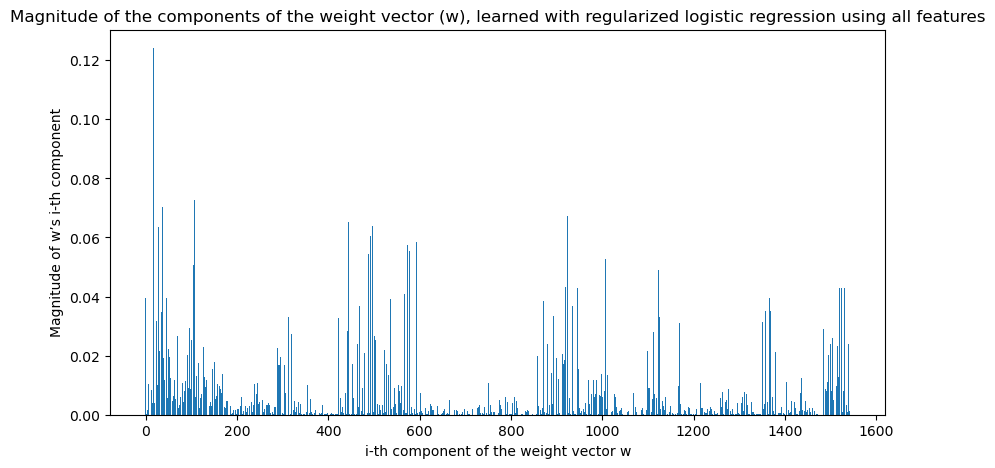

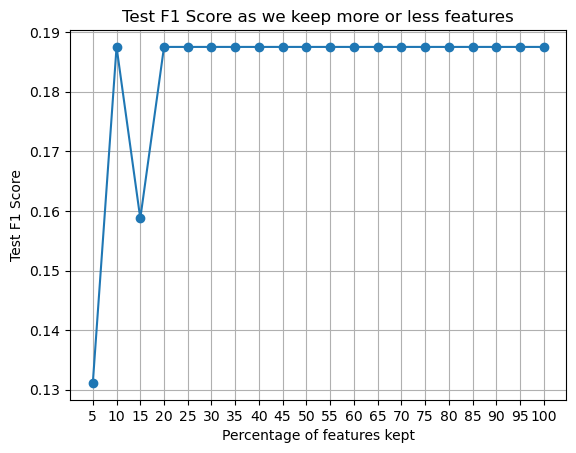

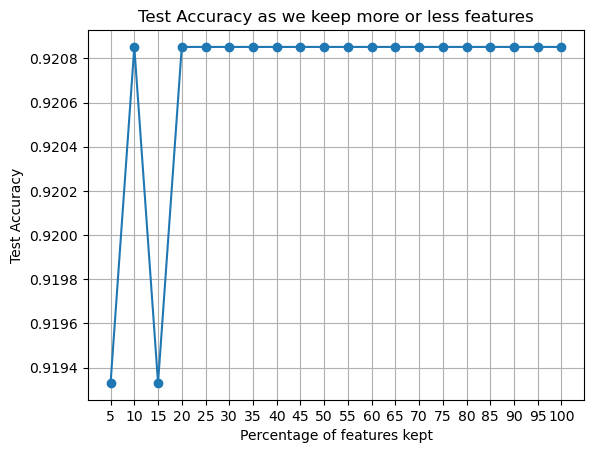

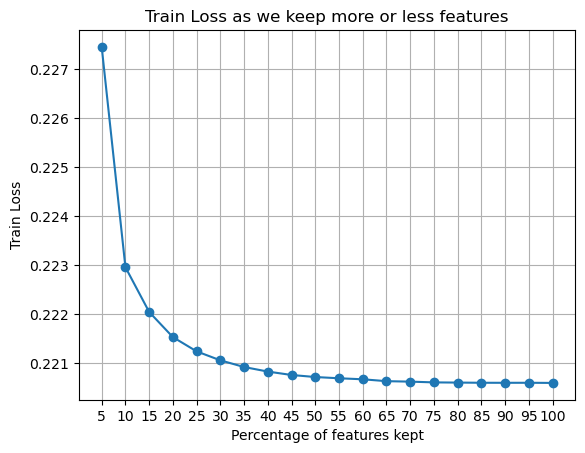

In [30]:
best_features_to_keep = select_most_significant_features(x_tr, y_tr)

# 3. Cross validation and model selection

## 3.1 Cross validation for regularized logistic regression

In [19]:
lambdas = 5 * 10 ** (-np.arange(2, 6, dtype=np.float64))
tx_train = build_tx(x_tr)[:, best_features_to_keep]
initial_w = np.zeros(tx_train.shape[1])
max_its = 50 * np.arange(1, 9)
gammas = [0.1, 0.5, 1]
fold_nums = 4
# WARNING: Takes a LOT of time (6 min)
best_f1, best_hps, scores = cross_validation_for_parameter_selection(
    y_tr, tx_train, kind='logistic', fold_nums=fold_nums, verbose=True, lambdas=lambdas, initial_w=initial_w, max_its=max_its, gammas=gammas
)


Cross validating for logistic            .	lambda_=0.05	initial_w=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]	max_its=[ 50 100 150 200 250 300 350 400]	gamma=0.1
k=0	k=1	k=2	k=3	
	F1 score after 400 iterations: 0.086646

Cross validating for logistic            .	lambda_=0.05	initial_w=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]	max_its=[ 50 100 150 200 250 300 350 400]	gamma=0.5
k=0	k=1	k=2	k=3	
	F1 score after 400 iterations: 0.086646

Cross validating for logistic            .	lambda_=0.05	initial_w=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [20]:
print("Best f1 score: {:.2f}\nBest hyperparameters:\n\t{}".format(best_f1, "\n\t".join(["{:10s} {}".format(k, v) for k, v in best_hps.items()])))

Best f1 score: 0.28
Best hyperparameters:
	lambda_    0.0005
	gamma      0.5


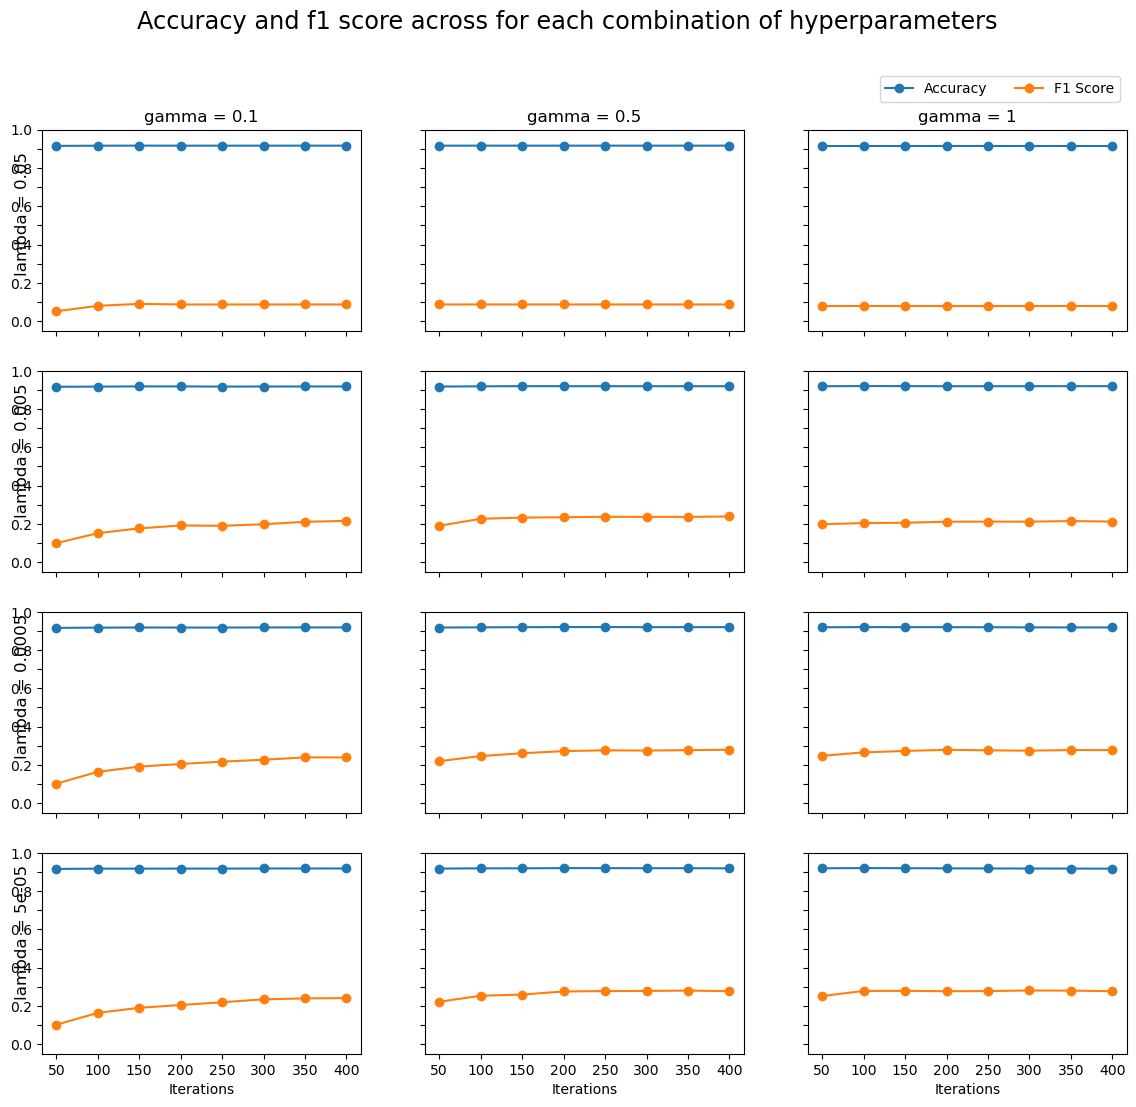

In [21]:
fig, axs = plt.subplots(nrows=len(lambdas), ncols=len(gammas), sharex=True, sharey=True)
fig.set_size_inches(14, 12)
fig.suptitle("Accuracy and f1 score across for each combination of hyperparameters", fontsize='xx-large')
for ilambda_, lambda_ in enumerate(lambdas):
    for igamma, gamma in enumerate(gammas):
        ll = scores[ilambda_][igamma]
        ax = axs[ilambda_][igamma]
        ax.plot(max_its, ll['accuracy'], 'o-', label='Accuracy')
        ax.plot(max_its, ll['f1'], 'o-', label='F1 Score')
        ax.set_xticks(max_its)
        ax.set_ybound(-0.05, 1)
        yticks = np.linspace(0, 1, 11)
        ax.set_yticks(yticks, ["{:.1f}".format(x) if i % 2 == 0 else "" for i, x in enumerate(yticks)])
        if igamma == 0:
            ax.text(0, 0.25, f"lambda = {lambda_}", rotation='vertical', fontsize='large')
        if ilambda_ == 0:
            ax.set_title(f"gamma = {gamma}")
            if igamma == len(gammas) - 1:
                ax.legend(loc='upper right', ncols=2, bbox_to_anchor=(1, 1.3))
        if ilambda_ == len(lambdas) - 1:
            ax.set_xlabel("Iterations")
fig.savefig('cross_validation')